In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

# Test Prophet with ICPW data

A very quick test of Facebook's [Prophet](https://facebook.github.io/prophet/) algorithm, as applied to ICPW.

## 1. Get data

Pick a station with long-term monitoring at fairly high frequency. `'CA01'` looks to have multiple samples per month for the full 27 year time period.

In [2]:
# Read data
xl_path = r'../../update_autumn_2018/results/all_chem_1990-2016.xlsx'
df_all = pd.read_excel(xl_path, sheet_name='data')
df_all.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,ALK-E_µEq/l,Al_µg/l,As_µg/l,COLOUR_,...,Pb_µg/l,Qs_m3/s,SO4_mg/l,SiO2_mg SiO2/l,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,Temp_oC,Zn_µg/l,pH_
0,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",1990-01-03,0,0,50.5,86.6,NaN,NaN,...,NaN,NaN,5.63,2.01,4.17,352.0,6.1,NaN,8.2,6.95
1,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",1990-01-09,0,0,50.0,84.0,NaN,NaN,...,NaN,NaN,5.53,2.01,3.94,598.0,5.7,NaN,8.2,6.05
2,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",1990-01-15,0,0,50.9,81.4,NaN,NaN,...,NaN,NaN,5.47,2.06,3.69,530.0,5.8,NaN,7.3,6.07
3,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",1990-01-24,0,0,56.6,76.8,NaN,NaN,...,NaN,NaN,5.34,2.05,3.71,493.0,4.7,NaN,8.6,5.93
4,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",1990-01-31,0,0,59.9,124.2,NaN,NaN,...,NaN,NaN,5.64,2.10,3.85,815.0,8.9,NaN,8.9,5.97


In [44]:
df_all.groupby(['station_code']).count().sort_values(['station_id'], ascending=False).head(20)

,station_id,station_name,sample_date,depth1,depth2,ALK-E_µEq/l,Al_µg/l,As_µg/l,COLOUR_,Ca_mg/l,...,Pb_µg/l,Qs_m3/s,SO4_mg/l,SiO2_mg SiO2/l,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,Temp_oC,Zn_µg/l,pH_
station_code,,,,,,,,,,,,,,,,,,,,,
Tr18_CA02,1849,1849,1849,1849,1849,1636,1626,0,0,1847,...,0,0,1848,1846,1846,1192,1380,0,1626,1848
Tr18_CA03,1847,1847,1847,1847,1847,1643,1563,0,0,1842,...,0,0,1846,1844,1845,1186,1373,0,1622,1846
Tr18_CA04,1831,1831,1831,1831,1831,1629,1602,0,0,1828,...,0,0,1829,1827,1829,1169,1358,0,1603,1829
Tr18_US_01434025,1810,1810,1810,1810,1810,1795,1697,0,0,1707,...,0,0,1800,1355,1799,0,0,1624,0,1798
Tr18_CA01,1809,1809,1809,1809,1809,1612,1801,0,0,1808,...,0,0,1808,1803,1809,1146,1340,0,1801,1809
Tr18_NO_LAE01,1422,1422,1422,1422,1422,1375,1,1,2,1376,...,1,1421,1382,218,1386,1382,668,0,1,1382
Tr18_NO_BIE01,1390,1390,1390,1390,1390,1087,0,0,0,1390,...,0,1390,1390,128,1390,1390,663,0,0,1390
Tr18_NO_DALELV,1390,1390,1390,1390,1390,1389,0,0,0,1390,...,2,1390,1390,50,1377,1377,425,0,0,1390
Tr18_NO_STE01,1364,1364,1364,1364,1364,1130,0,5,0,1363,...,0,1364,1363,124,1364,1364,644,0,5,1364


In [45]:
# Choose site
stn = 'Tr18_US_0143400680'

# Resample to monthly for chosen site
df = df_all.query('station_code == @stn')
df.index = df['sample_date']
df = df.resample('M').mean().reset_index()
df.head()

,sample_date,station_id,depth1,depth2,ALK-E_µEq/l,Al_µg/l,As_µg/l,COLOUR_,Ca_mg/l,Cd_µg/l,...,Pb_µg/l,Qs_m3/s,SO4_mg/l,SiO2_mg SiO2/l,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,Temp_oC,Zn_µg/l,pH_
0,1990-01-31,38468.0,0.0,0.0,-10.633333,223.762500,NaN,NaN,1.528924,NaN,...,NaN,NaN,5.508260,2.276667,2.562500,NaN,NaN,NaN,NaN,4.811111
1,1990-02-28,38468.0,0.0,0.0,-16.011111,363.766667,NaN,NaN,1.426892,NaN,...,NaN,NaN,5.424470,1.982857,2.322222,NaN,NaN,NaN,NaN,4.680000
2,1990-03-31,38468.0,0.0,0.0,-15.627273,291.281818,NaN,NaN,1.636627,NaN,...,NaN,NaN,5.303661,1.851000,2.718182,NaN,NaN,NaN,NaN,4.694545
3,1990-04-30,38468.0,0.0,0.0,-12.713333,272.612500,NaN,NaN,1.478765,NaN,...,NaN,NaN,5.450888,1.897500,2.215385,NaN,NaN,NaN,NaN,4.770000
4,1990-05-31,38468.0,0.0,0.0,-19.407143,308.684615,NaN,NaN,1.207411,NaN,...,NaN,NaN,5.347390,1.886429,3.136364,NaN,NaN,NaN,NaN,4.644286


## 2. Trends in TOC

In [46]:
# Get TOC
toc_df = df[['sample_date', 'TOC_mg C/l']].copy()
toc_df.columns = ['ds', 'y']
toc_df.head()

,ds,y
0,1990-01-31,2.562500
1,1990-02-28,2.322222
2,1990-03-31,2.718182
3,1990-04-30,2.215385
4,1990-05-31,3.136364


In [47]:
# Fit model
m = Prophet()
m.fit(toc_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


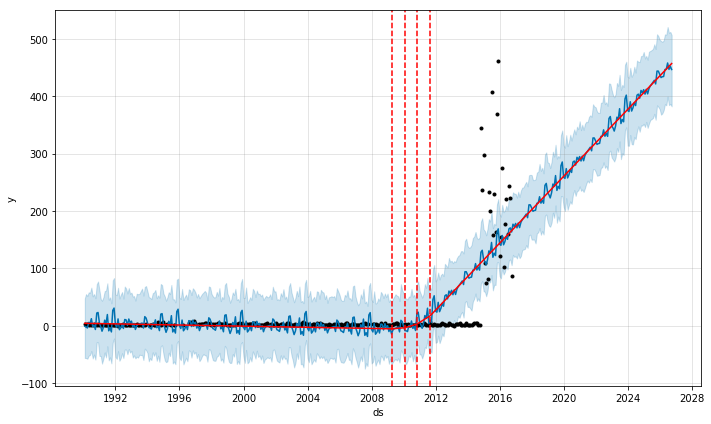

In [48]:
# Predict the next 10 years, with uncertainty
future = m.make_future_dataframe(periods=120, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)
plt.savefig(stn + '_TOC.png', dpi=300)

The data suggests that TOC increased rapidly from 1990 to around 2000, and then continued to increase more slowly.

## 3. Trends in SO4

**Note:** This is just raw SO4 for now (i.e. not corrected in any way).

In [41]:
# Get SO4
so4_df = df[['sample_date', 'SO4_mg/l']].copy()
so4_df.columns = ['ds', 'y']
so4_df.head()

,ds,y
0,1990-01-31,5.500
1,1990-02-28,2.750
2,1990-03-31,2.350
3,1990-04-30,1.925
4,1990-05-31,2.500


In [42]:
# Fit model
so4_df['cap'] = so4_df['y'].max()
m = Prophet(growth='logistic')
m.fit(so4_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


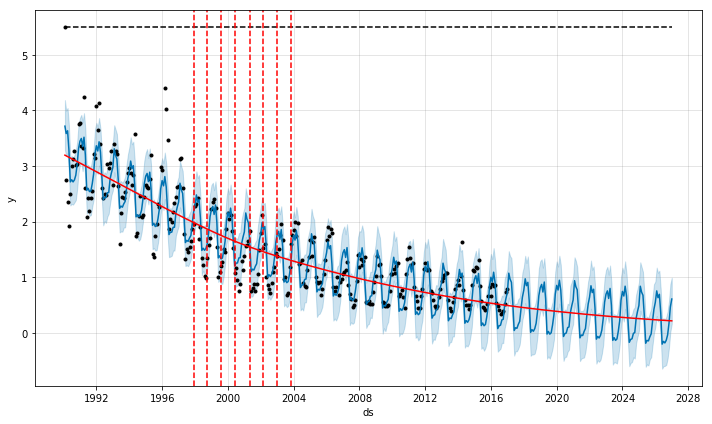

In [43]:
# Predict the next 10 years, with uncertainty
future = m.make_future_dataframe(periods=120, freq='M')
future['cap'] = so4_df['y'].max()
fcst = m.predict(future)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)
plt.savefig(stn + '_SO4.png', dpi=300)

Based on the above plots, SO4 at site `'CA01'` declined steadily until about 2004, then started to decrease more rapidly.